## Higgs Effective Field Theory (HEFT) Study: Training
> Created: Feb 12, 2024 Nicola de Filippis, Kurtis Johnson, Harrison B. Prosper<br>

### Introduction

In this notebook, we model the HEFT di-Higgs cross section[1] (per 15 GeV in the di-Higgs mass, $m_{hh}$) using a simple deep neural network in which the 15 GeV bin size is mapped to a dimensionless value of 0.01. The HEFT parameter space is defined by the 5 parameters $\theta = c_{hhh}, c_{t}, c_{tt}, c_{ggh}, c_{gghh}$. In this proof-of-principle, we set $c_{hhh} = c_{t} = 1$, which reduces the parameter space to 3 dimensions and yields the expression,

\begin{align}
    \sigma(m_{gg}, \theta) & = \boldsymbol{c}^T(\theta) \cdot \boldsymbol{b}(m_{hh}), 
\end{align}

for the cross section per bin, $\sigma$, where

\begin{align}
    \boldsymbol{c}^T(\theta) & = (1, 
                 c_{tt}, 
             c_{ggh}, 
             c_{gghh}, \nonumber\\
             &\quad\,\,\,\, c_{tt} c_{ggh},
             c_{tt} c_{gghh}, 
             c_{ggh}c_{gghh}, \nonumber\\
             &\quad\,\,\,\, c_{tt} c_{ggh}^2, 
             c_{gghh} c_{ggh}^2, 
             c_{tt}^2, 
             c_{gghh}^2, 
             c_{ggh}^2, 
             c_{ggh}^3), 
\end{align}

is a row matrix of polynomials in the HEFT parameters
and $\boldsymbol{b}(m_{hh})$ is a column matrix of coefficients.

### Model

We attempt to model the 13 functions $b_i(m_{hh})$ using a *single* deep neural network with one input, $m_{hh}$, and 13 outputs, one for each function. The training data for this notebook are prepared in the notebook `heft_prepare_traindata.ipynb`.

### References
  1. Lina Alasfar *et al.*, arXiv:2304.01968v1

In [2]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

# some simple dnn untilities
import dnnutil as dn

%matplotlib inline

device: cpu


In [3]:
# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

### Load training data

To reduce the dynamic range of the cross sections, let's transform them using the function
\begin{align}
    o(\sigma) & = \tanh( \sigma / \sigma_0 )
\end{align}
where $\sigma_0$ is a hyperparameter, which must be chosen large enough to ensure that $o(\sigma_\max) < 1$.

In [33]:
datafile = f'../data/heft_traindata.csv'

print('loading %s' % datafile)
df  = pd.read_csv(datafile)
print('number of rows: %d\n' % len(df))

print(f'min(sigma):  {df.sigma.min():10.5f}, '\
      f'avg(sigma):  {df.sigma.mean():10.5f},  max(sigma): {df.sigma.max():10.5f}\n')

# reduce dynamic range of cross sections

sigma0 = 0.3
df['target'] = np.tanh(df.sigma/sigma0)

print(f'min(target): {df.target.min():10.5f}, '\
      f'avg(target): {df.target.mean():10.5f},  max(target):  {df.target.max():10.7f}\n')

df[:5]

loading ../data/heft_traindata.csv
number of rows: 42400

min(sigma):     0.00000, avg(sigma):     0.06734,  max(sigma):    2.34208

min(target):    0.00000, avg(target):    0.12518,  max(target):   0.9999997



,CTT,CGGH,CGGHH,mhh,sigma,target
0,-3.0,0.6666,0.0666,0.105,1.178172,0.999224
1,-3.0,-0.6000,-0.8000,0.625,0.026347,0.087599
2,-1.0,0.8000,-0.8000,0.475,0.017784,0.059210
3,-1.0,0.6666,0.0666,0.425,0.009975,0.033239
4,-1.0,0.1333,0.0000,0.605,0.004213,0.014041


### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

In [34]:
# Fraction of the data assigned as test data and validation
ntrain    = 36000                # training sample size
tfraction = (1-ntrain/len(df))/2 # test fraction
vfraction = tfraction            # validation fraction

# Split data into a part for training, validation, and testing
train_data, valid_data, test_data = dn.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5]

train set size:         36000
validation set size:     3200
test set size:           3200


,CTT,CGGH,CGGHH,mhh,sigma,target
0,0.0,0.2666,0.3333,0.135,0.008662,0.028866
1,0.0,0.1333,0.2666,0.175,0.007307,0.024351
2,0.0,0.1333,0.3333,0.365,0.004260,0.014200
3,0.5,0.1333,0.2666,0.615,0.001452,0.004839
4,-1.5,-0.6000,0.6000,0.515,0.014306,0.047651


### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined by

\begin{align}
R_M(\omega) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\boldsymbol{x}_m, \omega)
\end{align*}
is the machine learning model with parameters $\omega$ to be determined by minimizing $R_M$. 
The quantity $x =  m_{hh}, c_{tt}, c_{ggh}, c_{gghh}$ are the inputs to the model and the targets $t$ are the predicted cross sections per 15 GeV in $m_{hh}$.

(Aside: The empirical risk $R_M$ approximates the **risk functional**
\begin{align}
R[f] & = \int \cdots \int \, p(t, \boldsymbol{x}) \, L(t, f(\boldsymbol{x}, \omega)) \, dt \, d\boldsymbol{x} ,
\end{align}
where the quantity $p(t, \boldsymbol{x}) \, dt\, d\boldsymbol{x}$ is the probability distribution of the training data from which the sample $\{ (t_m, \boldsymbol{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn.) 

We shall fit the model $f$ for the cross section by minimizing the **quadratic loss**

\begin{align}
    L(t, f) &= (t - f)^2 ,
\end{align}
where $f$ is the function
\begin{align}
    \sigma(m_{hh}, \theta) & = \boldsymbol{c}^T(\theta) \cdot \boldsymbol{b}(m_{hh}).
\end{align}

We use a single neural network to model the 13 functions $b_i(m_{hh})$. Note, minimizing the quadratic loss leads to the conclusion
\begin{align}
    f(\boldsymbol{x}, \omega^*) & = \int t \, p(t | \boldsymbol{x}) \, dt ,
\end{align}
where $\omega^*$ denotes the best-fit value of $\omega$ and $p(t | \boldsymbol{x}) = p(t,  \boldsymbol{x}) / p(\boldsymbol{x})$.

### Define model for cross section
`heftnet` models the mapping $f : m_{hh}, c_{tt}, c_{ggh}, c_{gghh} \rightarrow o(d\sigma)$ using the known functional dependence of the cross section on $m_{hh}$, the Wilson coefficients, $\theta = c_{tt}, c_{ggh}, c_{gghh}$, and the coefficients $\boldsymbol{b}$, and the known nonlinear function $o(*)$. The mapping $g : m_{hh} \rightarrow \boldsymbol{b}$ is modeled with a *single* neural network. The output function $o(*)$ is used to reduce the dynamic range of the cross sections.

In [47]:
%%writefile heftnet.py

name     = 'heftnet'
features = ['mhh', 'CTT', 'CGGH', 'CGGHH']
target   = 'target'
nodes    = 20
noutputs = 13
sigma0   = 0.3

import torch
import torch.nn as nn
import numpy as np

class HEFTNet(nn.Module):

    def __init__(self):

        # initial base class (nn.Module)
        super().__init__()

        # use a simple deep neural network to model the 13 coefficients b_i 
        # given m_hh.
        self.NN = nn.Sequential(nn.Linear(1, nodes),     nn.SiLU(),
                                nn.Linear(nodes, nodes), nn.SiLU(),
                                nn.Linear(nodes, nodes), nn.SiLU(),
                                nn.Linear(nodes, nodes), nn.SiLU(),
                                nn.Linear(nodes, nodes), nn.SiLU(),
                                nn.Linear(nodes, nodes), nn.SiLU(),
                                nn.Linear(nodes, nodes), nn.SiLU(),
                                nn.Linear(nodes, noutputs))

    # required method: this function computes the sqrt(cross section)
    def forward(self, x):
        # x.shape: (N, 4), where N is the batch size

        # compute vector of Wilson coefficient functions
        mhh, ctt, cggh, cgghh = x.transpose(1, 0)

        C = [np.ones_like(ctt), 
             ctt, 
             cggh, 
             cgghh, 
             ctt*cggh,
             ctt*cgghh, 
             cggh*cgghh, 
             ctt*cggh**2, 
             cgghh*cggh**2, 
             ctt**2, 
             cgghh**2, 
             cggh**2, 
             cggh**3]

        C = torch.Tensor(np.array(C).T)

        # compute b coefficients with NN
        b = self.coeffs(mhh)
        
        # compute cross section(s) per 15 GeV bin
        xsec = C.mul(b) 
        
        # protect against negative values
        xsec = xsec.sum(dim=1)

        # reduce dynamic range 
        return torch.tanh(xsec/sigma0)
        
    def coeffs(self, x):
        # must reshape input from (N, ) to (N, 1)
        return self.NN(x.view(-1, 1))

Overwriting heftnet.py


In [48]:
import heftnet as NN
importlib.reload(NN)

name     = NN.name
model    = NN.HEFTNet()
features = NN.features
target   = NN.target

modelfile  = '%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d\n' % dn.number_of_parameters(model))

# check model
X = torch.Tensor(test_data[['mhh','CTT', 'CGGH', 'CGGHH']].to_numpy())
print('input.size:  ', X.size())

Y = model(X)
print('output.size: ', Y.size())

heftnet
HEFTNet(
  (NN): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): SiLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): SiLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): SiLU()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): SiLU()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): SiLU()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): SiLU()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): SiLU()
    (14): Linear(in_features=20, out_features=13, bias=True)
  )
)
number of parameters: 2833

input.size:   torch.Size([3200, 4])
output.size:  torch.Size([3200])


### Train!

In [49]:
traces = ([], [], [])
traces_step = 100

Iteration vs average loss
iteration train-set valid-set
0        0 0.4653711 0.4432473
100      100 0.3262365 0.3124608
200      200 0.2138941 0.2040920
300      300 0.1082977 0.0969536
400      400 0.0664262 0.0597180
587600500 0.0001699 0.0002287    587500:    487500/0.00013326/   100000

stopping early!



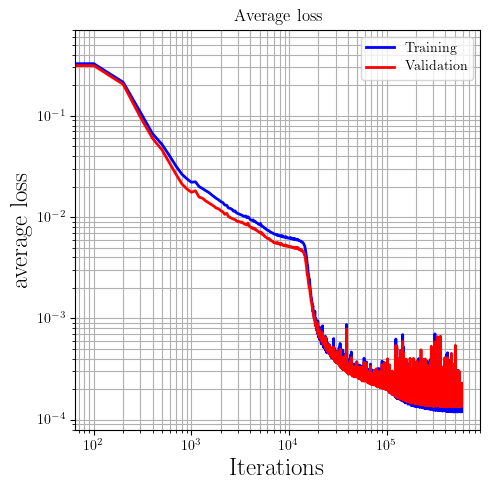

In [50]:
n_batch       = 128
n_iterations  = 10000000
early_stopping= 100000
learning_rate = 1.e-4

av_loss = dn.average_quadratic_loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

traces = dn.train(model, optimizer, 
                  modelfile, early_stopping,
                  av_loss,
                  dn.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

dn.plot_average_loss(traces)

### Apply trained model to test data

In [51]:
Load_model = True

if Load_model:
    print('load model: %s' % modelfile)
    modeldict = torch.load(modelfile)
    model.load_state_dict(modeldict)

# approximated cross sections (actually, some function of the cross sections)
model.eval()
y = model(X).detach().numpy()

# predicted cross sections (see comment above)
t = test_data['target'].to_numpy()

load model: heftnet.dict


### Plot NN prediction vs. predicted cross section

We're really plotting, some non-linear function $o(\sigma)$.

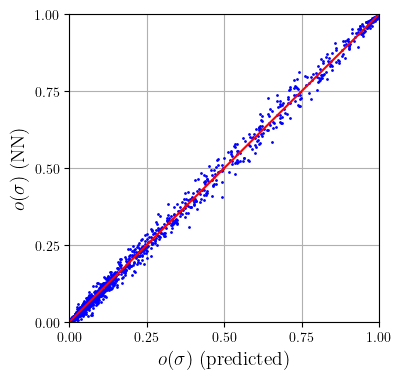

In [52]:
def plot_results(y, t, 
                 xmin=0.0, xmax=1.0, 
                 ymin=0.0, ymax=1.0, 
                 ftsize=14, 
                 filename='figures/fig_results.pdf'):

    # create an empty figure
    fig = plt.figure(figsize=(4, 4))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    
    ticks = np.linspace(xmin, xmax, 5)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(ticks)
    ax.set_xlabel(r'$o(\sigma)$ (predicted)', fontsize=ftsize)

    ax.set_ylim(ymin, ymax)
    ax.set_yticks(ticks)
    ax.set_ylabel(r'$o(\sigma)$ (NN)', fontsize=ftsize)
    
    ax.plot(y, t, 'b', marker='.', markersize=2, linestyle='')
    ax.plot([xmin, xmax], [ymin, ymax], linestyle='solid', color='red')

    ax.grid(True, which="both", linestyle='-')

    plt.savefig(filename)
    plt.show()

plot_results(y, t)

### Plot coefficients

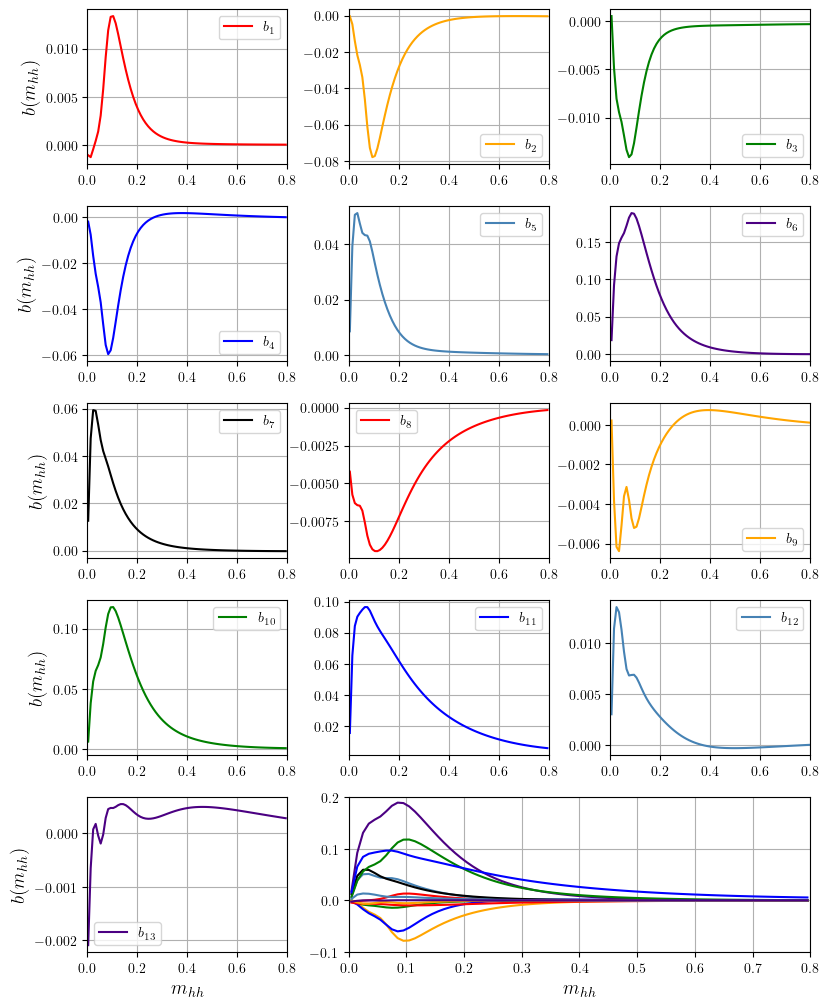

In [53]:
def plot_coeffs(dnn, ftsize=14):
    
    # define equally spaced points for m_hh
    xbins= 80
    xmin = 0
    xmax = xbins/100
    x = np.linspace(xmin, xmax, xbins+1)
    x = (x[1:]+x[:-1])/2

    # detach from computation tree and return coefficients as a numpy array
    b = dnn.coeffs( torch.Tensor(x) ).detach().numpy()
    nplots = len(b[0])
    
    # create a mosaic of plots
    # a b c
    # d e f
    # : : :
    # o p p
    # last plot occupies two slots
    fig, axes = plt.subplot_mosaic('abc;def;ijk;lmn;opp', 
                                   figsize=(8, 10))
    # need the following to make layout look reasonable
    fig.tight_layout()

    # get subplot keys a, b, c, etc.
    keys = list(axes.keys())
    keys.sort()

    kolor = ['red', 'orange', 'green', 'blue', 'steelblue', 'indigo', 'black']

    nrows = 5
    ncols = 3
    
    for i, key in enumerate(keys[:-1]):
        
        ax = axes[key]

        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)
            
        if i % ncols == 0:
            ax.set_ylabel(r'$b(m_{hh})$', fontsize=ftsize)

        # plot (i+1)th coefficient
        y = b.T[i]
        c = kolor[i % len(kolor)]
        index = i + 1
        ax.plot(x, y, color=c, label='$b_{%d}$' % index)
        ax.legend()
        ax.grid()

    # last plot: superimpose all coefficient plots
    ax = axes['p']
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)

    ymin = -0.10
    ymax =  0.20
    ax.set_ylim(ymin, ymax)
    
    for i in range(nplots):
        # plot (i+1)th coefficient
        y = b.T[i]
        c = kolor[i % len(kolor)]
        index = i + 1
        ax.plot(x, y, color=c)
    ax.grid()

    plt.savefig('figures/fig_coefficients.pdf')

plot_coeffs(model)

### Plot spectra

 1. Compute spectra approximated with the NN model.
 2. Compare with POWHEG spectra that have not been used in the training.

In [54]:
spectra = pd.read_csv('../data/heft_spectra.csv')
len(spectra), spectra[:5]

(340,
    CTT    CGGH   CGGHH        17        18        19        20        21  \
 0  0.5 -0.6000  0.0000  0.000069  0.000408  0.000525  0.000444  0.000657   
 1  0.5  0.1333  0.3333  0.005106  0.030635  0.033326  0.032770  0.029841   
 2 -1.5  0.0000  0.3333  0.006264  0.050164  0.077592  0.109697  0.115487   
 3 -1.0  0.8000  0.0000  0.002070  0.019394  0.032846  0.054304  0.071467   
 4  0.5 -0.4000  0.3333  0.002099  0.012663  0.017212  0.018394  0.017857   
 
          22        23  ...        87        88        89        90        91  \
 0  0.000665  0.000621  ...  0.000230  0.000235  0.000171  0.000161  0.000171   
 1  0.030162  0.026020  ...  0.000933  0.001214  0.000730  0.000853  0.000686   
 2  0.142210  0.161502  ...  0.003657  0.003392  0.003662  0.002351  0.002873   
 3  0.090617  0.101578  ...  0.000931  0.001479  0.001774  0.001038  0.001777   
 4  0.016186  0.016581  ...  0.001463  0.000797  0.000732  0.001081  0.000667   
 
          92        93        94        95

In [57]:
def get_spectra(model, df, row):

    # get column names
    columns= list(df.columns)
    params = columns[:3]
    bins   = columns[3:]
    
    xbins = len(bins)
    xmin  = 0
    xmax  = xbins/100
    
    # define mhh values
    x = np.linspace(xmin, xmax, xbins+1)
    x = (x[1:]+x[:-1])/2

    # get parameter names
    ctt, cggh, cgghh = df[params].iloc[row]

    # create input data
    inputs = []
    for mhh in x:
        inputs.append([mhh, ctt, cggh, cgghh])

    # get predicted cross section
    spectrum = df[bins].iloc[row].to_numpy() # predicted spectrum  

    # get approximated cross section
    inputs = torch.Tensor(np.array(inputs))
    model.eval()   
    y = model(inputs).detach().numpy()       # approximated spectrum

    # map to cross section
    y = sigma0 * np.arctanh(y) 

    return spectrum.sum(), x, y, spectrum, ctt, cggh, cgghh

In [58]:
M = 39
data = []
for row in range(M):
    data.append( get_spectra(model, spectra, row) )

# sort in decreasing cross section
data.sort()
data.reverse()

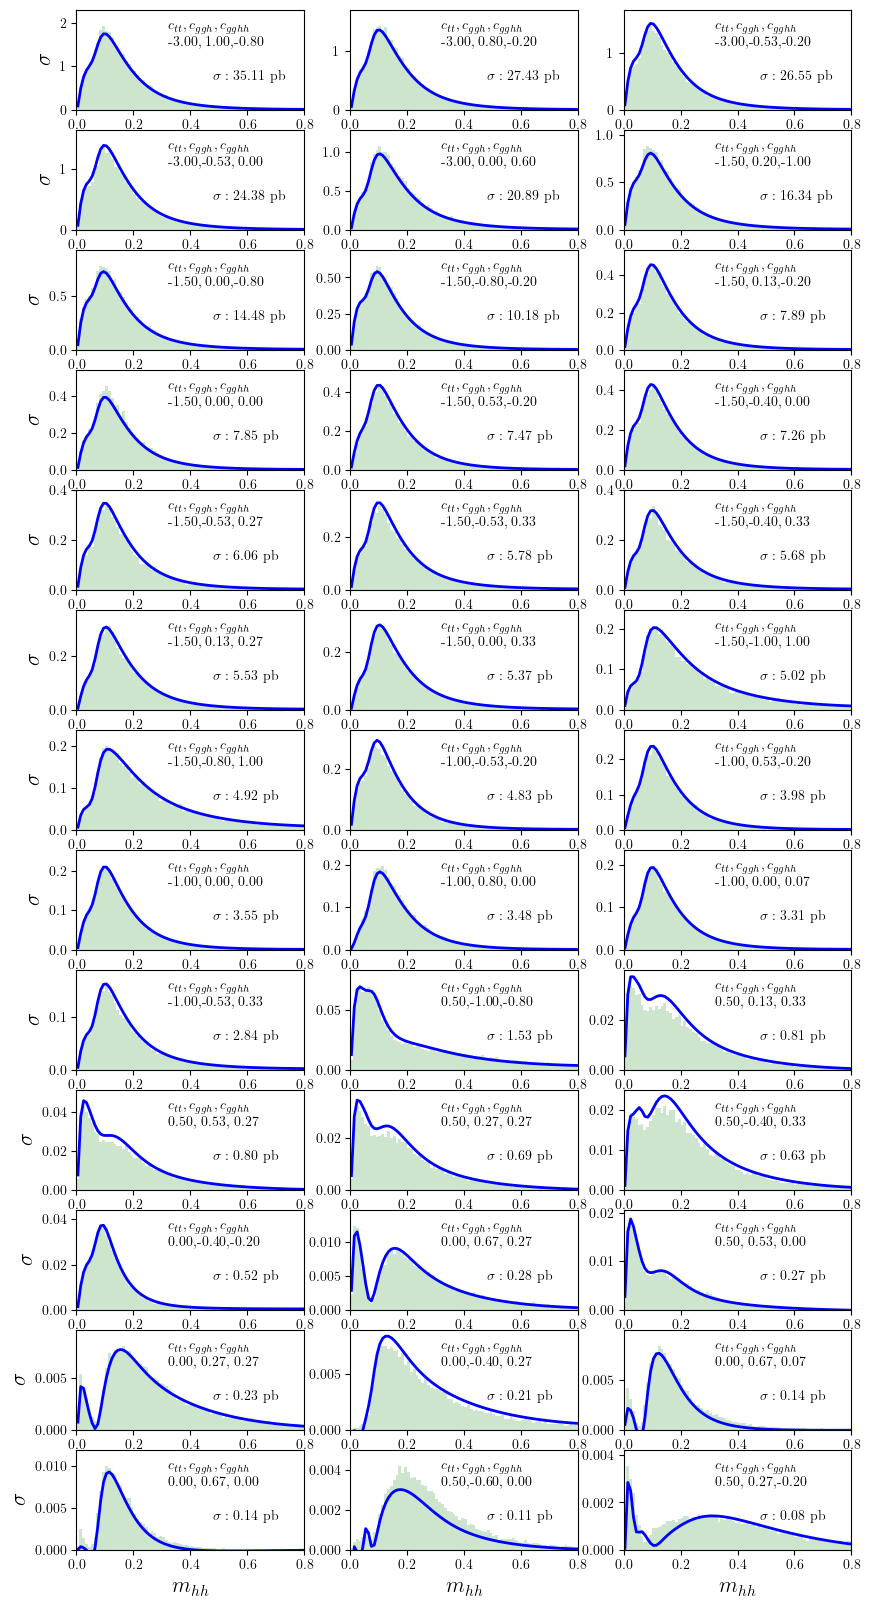

In [59]:
def plot_spectra(data, 
                 ftsize=16, 
                 filename='fig_spectra_comparisons.pdf'):

    plt.rcParams.update({'font.size': 10})
    
    _, x, y, s, _,_,_ = data[0]
    xbins = len(x)
    xmin, ymin  = 0, 0
    xmax = xbins/100

    # create an empty figure
    fig = plt.figure(figsize=(10, 20))
    fig.tight_layout()

    # work out number of columns and number of plots
    ncols = 3
    nrows = len(data) // ncols
    ndata = nrows * ncols

    # loop over coefficients

    for i, (total_xsec, x, y, f, ctt, cggh, cgghh) in enumerate(data):

        index = i+1
        ax  = fig.add_subplot(nrows, ncols, index)

        # setup x-axis
        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)

        # setup y-axis
        ymax = 1.2 * f.max()
        ax.set_ylim(ymin, ymax)
        
        if i % ncols == 0:
            ax.set_ylabel(r'$\sigma$', fontsize=ftsize)

        # annotate plot
        xpos = xmin + 0.40 * (xmax-xmin)
        ypos = ymin + 0.80 * (ymax-ymin)
        ystep= (ymax-ymin)/6
        ax.text(xpos, ypos, r'$c_{tt},c_{ggh},c_{gghh}$'); ypos -= ystep
        ax.text(xpos, ypos, '%5.2f,%5.2f,%5.2f' % (ctt, cggh, cgghh)); ypos -= ystep
        
        xpos = xmin + 0.60 * (xmax-xmin)
        ypos -= ystep
        ax.text(xpos, ypos, r'$\sigma:$ %5.2f pb' % total_xsec)
        
        # predicted spectra
        ax.hist(x, bins=xbins, range=(xmin, xmax), weights=f, 
                    color='green', alpha=0.2)

        # NN-approximated spectra
        ax.plot(x, y, color='blue', linewidth=2)

    plt.savefig(filename)
    plt.show()

plot_spectra(data)

In [53]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)